# Import Libraries

In [1]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cuda


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
x_1 = np.linspace(-1,1,256)  # 256 points between -1 and 1 [256x1]
x_2 = np.linspace(1,-1,256)  # 256 points between 1 and -1 [256x1]

X, Y = np.meshgrid(x_1,x_2) 

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))

# Domain bounds
lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

a_1 = 1 
a_2 = 1

k = 1

usol = np.sin(a_1 * np.pi * X) * np.sin(a_2 * np.pi * Y) #solution chosen for convinience  

u_true = usol.flatten('F')[:,None] 

# Training Data

In [4]:
def trainingdata(N_u,N_f):
    
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None]))
    leftedge_u = usol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None]))
    rightedge_u = usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None]))
    topedge_u = usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))
    bottomedge_u = usol[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx[0:N_u],:]      #choose corresponding u
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points 
    
    return X_f_train, X_u_train, u_train 


# Physics Informed Neural Network

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            

    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
                        
        '''     
        Alternatively:
        
        a = self.activation(self.fc1(a))
        a = self.activation(self.fc2(a))
        a = self.activation(self.fc3(a))
        a = self.fc4(a)
        
        '''
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def loss_PDE(self, x_to_train_f):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx = autograd.grad(u_x,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        u_xx_1 = u_xx[:,[0]]
        
        u_xx_2 = u_xx[:,[1]]
                
        q = ( -(a_1*np.pi)**2 - (a_2*np.pi)**2 + k**2 ) * torch.sin(a_1*np.pi*x_1_f) * torch.sin(a_2*np.pi*x_2_f)
                        
        f = u_xx_1 + u_xx_2 + k**2 * u - q 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_u_train, u_train, X_f_train)
        
        error_vec, _ = PINN.test()
        
        print(loss,error_vec)
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        u_pred = self.forward(X_u_test_tensor)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = np.reshape(u_pred.cpu().detach().numpy(),(256,256),order='F') 
        
        return error_vec, u_pred

# *Solution Plot*

In [6]:
def solutionplot(u_pred,X_u_train,u_train):

    #Ground truth
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(x_1, x_2, usol, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Ground Truth $u(x_1,x_2)$', fontsize=15)

    # Prediction
    plt.subplot(1, 3, 2)
    plt.pcolor(x_1, x_2, u_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Predicted $\hat u(x_1,x_2)$', fontsize=15)

    # Error
    plt.subplot(1, 3, 3)
    plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title(r'Absolute error $|u(x_1,x_2)- \hat u(x_1,x_2)|$', fontsize=15)
    plt.tight_layout()

    plt.savefig('Helmholtz_non_stiff.png', dpi = 500, bbox_inches='tight')

# Main

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
tensor(84.7494, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1221, device='cuda:0', grad_fn=<DivBackward0>)
tensor(42.4577, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8855, device='cuda:0', grad_fn=<DivBackward0>)
tensor(31.9337, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7464, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.4844, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.5852, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3184, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.4341, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5642, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.4751, device='cuda:0', grad_fn=<Di

/tmp/ipykernel_3553/3902590039.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_1, x_2, usol, cmap='jet')
/tmp/ipykernel_3553/3902590039.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_1, x_2, u_pred, cmap='jet')
/tmp/ipykernel_3553/3902590039.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, 

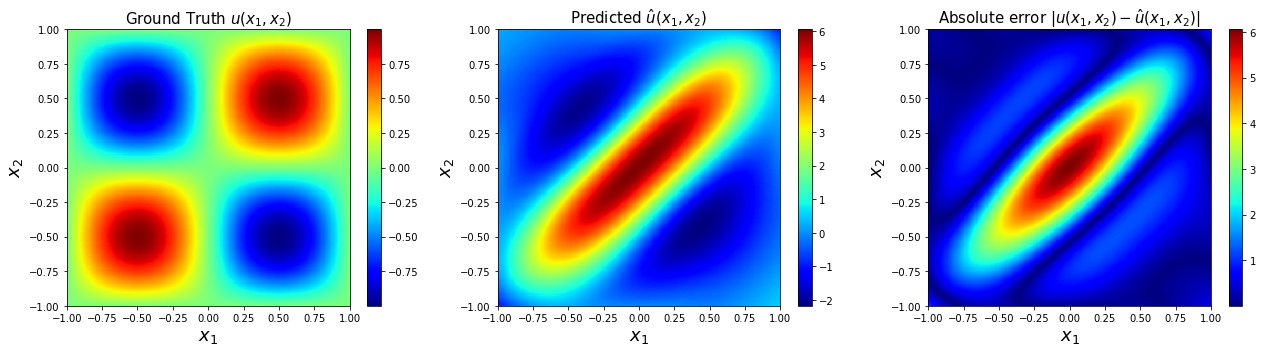

In [8]:
N_u = 400 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
u_train = torch.from_numpy(u_train_np_array).float().to(device)
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

layers = np.array([2, 50, 50, 50, 1]) #3 hidden layers

PINN = Sequentialmodel(layers)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)

params = list(PINN.parameters())

'''Optimization'''

'L-BFGS Optimizer'

# optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1, 
#                               max_iter = 1000, 
#                               max_eval = None, 
#                               tolerance_grad = 1e-06, 
#                               tolerance_change = 1e-09, 
#                               history_size = 100, 
#                               line_search_fn = 'strong_wolfe')


# start_time = time.time()

# optimizer.zero_grad()     # zeroes the gradient buffers of all parameters

# optimizer.step(PINN.closure)


'Adam Optimizer'

optimizer = optim.Adam(PINN.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

max_iter = 1000

start_time = time.time()

for i in range(max_iter):

    loss = PINN.loss(X_u_train, u_train, X_f_train)
           
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    
    loss.backward() #backprop

    optimizer.step()
    
    if i % (max_iter/10) == 0:

        error_vec, _ = PINN.test()

        print(loss,error_vec)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))


''' Solution Plot '''
solutionplot(u_pred,X_u_train,u_train)